## Read data

Read data and divaded to three part train, valid and test datasets.

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


## Convert images to tensors 

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:03<00:00, 263.88it/s]


# Model Dogs Identification

In [3]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [4]:
def VGG19_model():
    # create the base pre-trained model
    base_model = VGG19(weights='imagenet', include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(len(dog_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    return model

In [5]:
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 100


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)
tensorborad = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, 
            write_images=True, embeddings_freq=0, embeddings_layer_names=None,
            embeddings_metadata=None, embeddings_data=None)
model = VGG19_model()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [6]:
history=model.fit(train_tensors, train_targets,validation_data=(valid_tensors,valid_targets), 
                    epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorborad], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
 - 53s - loss: 4.6827 - val_loss: 4.2884

Epoch 00001: val_loss improved from inf to 4.28836, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/100
 - 52s - loss: 3.9138 - val_loss: 3.7274

Epoch 00002: val_loss improved from 4.28836 to 3.72745, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/100
 - 53s - loss: 3.3703 - val_loss: 3.3617

Epoch 00003: val_loss improved from 3.72745 to 3.36167, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/100
 - 53s - loss: 3.0128 - val_loss: 3.1069

Epoch 00004: val_loss improved from 3.36167 to 3.10693, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/100
 - 53s - loss: 2.7539 - val_loss: 2.9396

Epoch 00005: val_loss improved from 3.10693 to 2.93958, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 6/100
 - 53s - loss: 2.5605 - val_loss: 2.8474

Epoch 00006: val_loss improved from 2.93958 to 2.8473

 - 53s - loss: 0.1894 - val_loss: 4.1490

Epoch 00069: val_loss did not improve from 2.55336
Epoch 70/100
 - 53s - loss: 0.1841 - val_loss: 4.0733

Epoch 00070: val_loss did not improve from 2.55336
Epoch 71/100
 - 53s - loss: 0.1739 - val_loss: 4.1737

Epoch 00071: val_loss did not improve from 2.55336
Epoch 72/100
 - 53s - loss: 0.1688 - val_loss: 4.1581

Epoch 00072: val_loss did not improve from 2.55336
Epoch 73/100
 - 54s - loss: 0.1579 - val_loss: 4.1194

Epoch 00073: val_loss did not improve from 2.55336
Epoch 74/100
 - 54s - loss: 0.1489 - val_loss: 4.1907

Epoch 00074: val_loss did not improve from 2.55336
Epoch 75/100
 - 54s - loss: 0.1457 - val_loss: 4.1787

Epoch 00075: val_loss did not improve from 2.55336
Epoch 76/100
 - 53s - loss: 0.1423 - val_loss: 4.2175

Epoch 00076: val_loss did not improve from 2.55336
Epoch 77/100
 - 53s - loss: 0.1310 - val_loss: 4.5001

Epoch 00077: val_loss did not improve from 2.55336
Epoch 78/100
 - 53s - loss: 0.1292 - val_loss: 4.4209

Epoc

In [13]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 35.6459%


### Set trainable value
change the trainable value for the first 130 and retrain the other layer.

In [10]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_1
23 dense_1
24 dense_2


In [14]:
epochs = 100
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history=model.fit(train_tensors, train_targets,validation_data=(valid_tensors,valid_targets), 
                    epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorborad], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 80s 12ms/step - loss: 15.9159 - val_loss: 15.9637

Epoch 00001: val_loss did not improve from 2.55336
Epoch 2/100
6680/6680 [==============================] - 80s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00002: val_loss did not improve from 2.55336
Epoch 3/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00003: val_loss did not improve from 2.55336
Epoch 4/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00004: val_loss did not improve from 2.55336
Epoch 5/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00005: val_loss did not improve from 2.55336
Epoch 6/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00006: val_loss did not improve from 2.55336

6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00052: val_loss did not improve from 2.55336
Epoch 53/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00053: val_loss did not improve from 2.55336
Epoch 54/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00054: val_loss did not improve from 2.55336
Epoch 55/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00055: val_loss did not improve from 2.55336
Epoch 56/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00056: val_loss did not improve from 2.55336
Epoch 57/100
6680/6680 [==============================] - 79s 12ms/step - loss: 15.9613 - val_loss: 15.9637

Epoch 00057: val_loss did not improve from 2.55336
Epoch 58/100
6680/6680 [=============================

dict_keys(['val_loss', 'loss'])


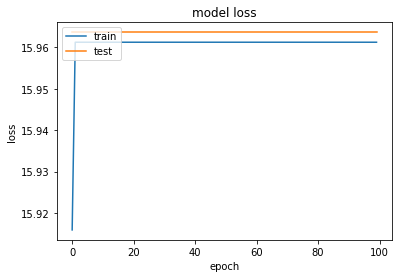

In [15]:
import matplotlib.pyplot as plt                        
%matplotlib inline 

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Training result

In [21]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

dog_breed_predictions_train=[np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in train_tensors]
# report train accuracy
train_accuracy = 100*np.sum(np.array(dog_breed_predictions_train)==np.argmax(train_targets, axis=1))/len(dog_breed_predictions_train)
print('traning accuracy: %.4f%%' % train_accuracy)

dog_breed_predictions_valid=[np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]
# report valid accuracy
validation_accuracy = 100*np.sum(np.array(dog_breed_predictions_valid)==np.argmax(valid_targets, axis=1))/len(dog_breed_predictions_valid)
print('Validation accuracy: %.4f%%' % train_accuracy)

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

traning accuracy: 64.5659%
Validation accuracy: 64.5659%
Test accuracy: 35.6459%
